In [48]:
include("cruise_control.jl");
state_dim = 4;
M = 1;

In [38]:
for s in system(1, 1).resetmaps
    @show s.A
end

s.A = [1.0 -0.5 0.5 0.0; 0.125 0.875 0.125 0.0; 0.125 0.125 0.875 0.5; 0.0 0.0 0.0 0.0]
s.A = [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0]


In [2]:
import Mosek
using MathOptInterfaceMosek
sdp_factory = with_optimizer(MosekOptimizer, QUIET=true);

In [40]:
using JuMP
const MOI = JuMP.MOI
const Sets = SOS.SetProg.Sets

function mpcstep(hs, modes, x0, y0, soc, usetol)
    m = Model(sdp_factory)
    nt = length(modes)
    yvar = true
    if yvar
        y = @variable m [1:nt]
    else
        y = Vector{JuMP.AffExpr}(undef, nt)
    end
    proju = true
    dim = proju ? state_dim - 1 : state_dim
    xvar = true
    if xvar
        x = @variable m [1:nt, 1:dim]
    else
        x = Matrix{JuMP.AffExpr}(undef, nt, dim)
    end
    if proju
        @variable(m, u[1:(nt-1)], lower_bound=-U, upper_bound=U)
    else
        u = @variable m [1:(nt-1)]
    end
    #@show x0
    if x0 isa Vector
        if xvar
            cx0 = @constraint m x[1, :] .== x0[1:dim]
        else
            x[1, :] .= x0[1:dim]
        end
    else
        if xvar
            cx0 = @constraint m x[1, 2:3] .<= x0
        else
            @variable(m, x_0[1:dim])
            cx0 = [@constraint(m, x_0[2] in MOI.LessThan(x0)),
                   @constraint(m, x_0[3] in MOI.LessThan(x0))]
            x[1, :] = x_0
        end
    end
    if yvar
        cy0 = @constraint m y[1] == y0
    else
        y[1] = y0
    end
    if usetol
        tol = @variable m lower_bound=0
    end
    cset = Vector{Any}(undef, nt)
    cdynx = Vector{Any}(undef, nt-1)
    cdyny = Vector{Any}(undef, nt-1)
    for i in 1:nt
        q = modes[i]
        @assert !Polyhedra.hashyperplanes(stateset(hs, q))
        if soc === nothing # || true
            for h in halfspaces(stateset(hs, q))
                # h.a[end] != 0 means that it is u <= 4 or u >= -4 for which we don't want to use tolerance
                # It is a hard constraint
                # Same for h.a[1] != 0
                # @constraint m dot(x[i, :], h.a) <= h.β + (usetol && iszero(h.a[1]) && iszero(h.a[end])? tol : 0.)
                @constraint m dot(x[i, :], h.a[1:dim]) <= h.β + (usetol ? tol : 0.)
            end
        end
        if soc !== nothing
            set = soc[q]
            if proju
                # zero_eliminate on Householder gives Householder{Unknown} so let's not project
                # but rather introduce a lifting variable
                lift_u = @variable(m)
                cset[i] = @constraint(m, [x[i, 1:dim]; lift_u] in set)
            else
                cset[i] = @constraint(m, x[i, 1:dim] in set)
            end
        end
        if i < nt
            s = modes[i+1]
            edge = LightGraphs.Edge(q, s)
            @assert 1 == length(hs.automaton.Σ[edge])
            t = HybridSystems.LightTransition(edge, first(keys(hs.automaton.Σ[edge])))
            σ = symbol(hs.automaton, t)
            r = hs.resetmaps[σ]
            A = r.A[1:dim, 1:dim]
            if proju
                B = r.A[1:dim, end]
            else
                B = r.B
            end
            if xvar
                cdynx[i] = @constraint m x[i+1, :] .== A * x[i, :] + B .* u[i]
            else
                x[i+1, :] = A * x[i, :] + B .* u[i]
            end
            if σ == 1
                if yvar
                    cdyny[i] = @constraint m y[i+1] == y[i] + h * x[i, state_dim-1]
                else
                    y[i+1] = y[i] + h * x[i, state_dim-1]
                end
            else
                if yvar
                    cdyny[i] = @constraint m y[i+1] == y[i]
                else
                    y[i+1] = y[i]
                end
            end
        end
    end
    @objective(m, Max, y[end] - (usetol ? 1000tol : 0.))
    #println(m)
    JuMP.optimize!(m)
    #@show JuMP.termination_status(m)
    #@show JuMP.primal_status(m)
    #@show JuMP.dual_status(m)

    feasible = JuMP.termination_status(m) != MOI.INFEASIBLE
    if feasible
        @assert JuMP.termination_status(m) == MOI.OPTIMAL || JuMP.termination_status(m) == MOI.SLOW_PROGRESS
        if JuMP.termination_status(m) == MOI.SLOW_PROGRESS
            @warn("Slow Progress")
        end
        if JuMP.primal_status(m) != MOI.FEASIBLE_POINT
            error("Primal Status: $(JuMP.primal_status(m))")
        end
    else
        @assert JuMP.dual_status(m) == MOI.INFEASIBILITY_CERTIFICATE
        #@show JuMP.dual.(cx0)
        #@show JuMP.dual(cy0)
        #@show JuMP.dual.(cset)
        #@show map(c -> JuMP.dual.(c), cdynx)
        #@show JuMP.dual.(cdyny)
    end
    xval = JuMP.value.(x)[2:end,:]
    if proju
        xval = [xval JuMP.value.(u)]
    end
    feasible, xval, JuMP.value.(y)[2:end]
end

mpcstep (generic function with 1 method)

In [4]:
function solvempc(nt, nsteps, setvar::Union{Nothing, Function}=nothing; sym=false, kws...)
    T = nsteps
    na = div(nt,2)-1
    nN = nt-T-na
    N = 1 + (T+1) * length(v)
    startstate = N
    modes = [fill(startstate, nN); collect((T+1):-1:2); fill(1, na)]
    @assert length(modes) == nt
    y = Vector{Float64}(undef, nt)
    x = Matrix{Float64}(undef, nt, state_dim)
    x[1, :] = [repeat([0., 10.], M); 10.; 0.]
    y[1] = -10. * h
    last = nt
    if setvar !== nothing
        #soc = elltosoc.(fullsolve(T, M, h, setvar, volume_heuristic=volume_heuristic,
        #                oneshot=false, onlyone=false))
        if sym
            soc = symsolve(T, M, setvar)
        else
            soc = fullsolve(T, M, setvar; oneshot=false, onlyone=false, kws...)
        end
        #soc = fill(soc[1], length(soc))
        #return soc
    else
        soc = nothing
    end
    hs = system(M, T, N=N)
    for i in 1:(nt-1)
        #@show i
        j = min(nt, i + nsteps)
        _step(usetol) = mpcstep(hs, modes[i:j], i == 1 ? zeros(4) : x[i, :], y[i], soc, usetol)
        feasible, X, Y = _step(false)
        #@show feasible
        if !feasible
            feasible, X, Y = _step(true)
            @show feasible
        end
        while !feasible && nsteps > 1
            nsteps -= 1
            ds, X, Y = _step(true)
            @show nsteps
        end
        x[i+1, :] = X[1, :]
        y[i+1] = Y[1]
        if last == nt && (!feasible || !(X[1, :] in stateset(hs, modes[i+1])))
            @show X[1, :]
            @show stateset(hs, modes[i+1])
            last = i+1
            #break
        end
    end
    if last < nt
        @warn("$last < $nt")
    end
    take = last
    @show nt
    @show take
    @show last
    #take = nt
    if take > nN
        [x[2:nN, :]; x[(nN+2):take, :]], [y[2:nN]; y[(nN+2):take]]
    else
        x[2:take, :], y[2:take]
    end
end

solvempc (generic function with 2 methods)

In [49]:
if true
    minsafe = 5
    nt = 40
else
    #nt = 77
    minsafe = 24
    nt = 152
end
tswitch = fill(h * (nt-2) / 2, 2)
t = [0.]
for i in 2:(nt-2)
    push!(t, t[end] + h)
end

In [102]:
using DataStructures
XY = OrderedDict{String, Tuple{Matrix{Float64}, Vector{Float64}}}();

In [7]:
system(M, minsafe-1).resetmaps[1].A

4×4 Array{Float64,2}:
 1.0  -0.5  0.5  0.0
 0.5   0.5  0.5  0.0
 0.5   0.5  0.5  0.5
 0.0   0.0  0.0  0.0

In [103]:
XY["unsafe"] = solvempc(nt, minsafe-1)
#@assert 55 == XYok["unsafe"][2]

feasible = true
feasible = true
feasible = true
feasible = true
X[1, :] = [-0.991988, 1.26074, 1.26074, 0.887088]
stateset(hs, modes[i + 1]) = HalfSpace([-1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, -1.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, 1.0], 1.0) ∩ HalfSpace([0.0, -1.0, 0.0, 0.0], 1.0) ∩ HalfSpace([0.0, 0.0, -1.0, 0.0], 1.0) ∩ HalfSpace([0.0, 1.0, 0.0, 0.0], 1.0) ∩ HalfSpace([0.0, 0.0, 1.0, 0.0], 1.0)
feasible = true
feasible = true
feasible = true
feasible = true
feasible = true
feasible = true
feasible = true
nt = 40
take = 22
last = 22


┌ Warning: 22 < 40
└ @ Main In[4]:53


([0.0 0.0 0.5 1.0; 0.25 0.125 0.875 1.0; … ; -0.548444 1.61963 0.73254 -1.0; -0.991988 1.26074 1.26074 0.887088], [-5.0, -4.75, -4.3125, -3.75, -3.39063, -2.90625, -2.29688, -1.8125, -1.30035, -0.627894, 0.159916, 0.983089, 1.83573, 2.71294, 3.71294, 4.60549, 5.53028, 6.2373, 6.77697, 7.14324])

In [104]:
XY["ellipsoids"] = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h), volume_heuristic=nth_root);

nstates(hs) = 6
Computing set 1
MOI.get(model, MOI.SolveTime()) = 0.0036869049072265625
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.8339403023509967
Computing set 2
MOI.get(model, MOI.SolveTime()) = 0.003571033477783203
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.8788411310003909
Computing set 3
MOI.get(model, MOI.SolveTime()) = 0.003446817398071289
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 0.8371623954122568
Computing set 4
MOI.get(model, MOI.

In [66]:
XY["quadratic"] = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h));

nstates(hs) = 6
Computing set 1
MOI.get(model, MOI.SolveTime()) = 0.002056121826171875
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 2.6666666667149035
Computing set 2
MOI.get(model, MOI.SolveTime()) = 0.0030601024627685547
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 2.8685537548390556
Computing set 3
MOI.get(model, MOI.SolveTime()) = 0.003225088119506836
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 2.8734741948057105
Computing set 4
MOI.get(model, MOI.

In [53]:
XY["quadratic"]  = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=2, point=h));

nstates(hs) = 6
Computing set 1
MOI.get(model, MOI.SolveTime()) = 0.002460956573486328
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 21.33333333944897
Computing set 2
MOI.get(model, MOI.SolveTime()) = 0.0034339427947998047
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 22.912893672769144
Computing set 3
MOI.get(model, MOI.SolveTime()) = 0.0030961036682128906
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 22.93651866582841
Computing set 4
MOI.get(model, MOI.S

┌ Warning: 21 < 40
└ @ Main In[4]:53


In [107]:
XY["quartic"] = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=4, point=h));

nstates(hs) = 6
Computing set 1
MOI.get(model, MOI.SolveTime()) = 0.0632789134979248
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 76.79558436810976
Computing set 2
MOI.get(model, MOI.SolveTime()) = 0.062744140625
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 82.80576474211729
Computing set 3
MOI.get(model, MOI.SolveTime()) = 0.05501103401184082
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 84.74455995222735
Computing set 4
MOI.get(model, MOI.SolveTime()) 

In [108]:
XY["sextic"] = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=6, point=h));

nstates(hs) = 6
Computing set 1
MOI.get(model, MOI.SolveTime()) = 4.712260007858276
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 684.878785134573
Computing set 2
MOI.get(model, MOI.SolveTime()) = 3.0121190547943115
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 770.411846875277
Computing set 3
MOI.get(model, MOI.SolveTime()) = 3.799837827682495
JuMP.termination_status(model) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(model) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.objective_value(model) = 789.036562180584
Computing set 4
MOI.get(model, MOI.S

┌ Warning: Slow Progress
└ @ Main In[40]:122


nt = 40
take = 40
last = 40


In [15]:
#XYok["octic"] = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=8, point=h));

In [118]:
import Plots
Plots.pyplot()
_savefig(name) = Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControlPoly$name.eps");
#XY = [("unsafe 8", XYko["unsafe 8"])];
XY = XYok;
plotsize = (800, 400);
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
colors = Dict("unsafe" => blu, "ellipsoids" => gre, "quadratic" => yel,
              "quartic" => ora, "sextic" => red);
function baseplot(ylabel, yticks)
    Plots.plot(legendfont=Plots.font(13), guidefont=Plots.font(16), tickfont=Plots.font(10), grid=false,
               ylabel=ylabel, yticks=yticks, size=plotsize, xlabel="Time [s]")
end
function limit_line(t1, t2, y)
    Plots.plot!([t1, t2], [y, y], linewidth=0.5, color=:black, label="")
end

limit_line (generic function with 2 methods)

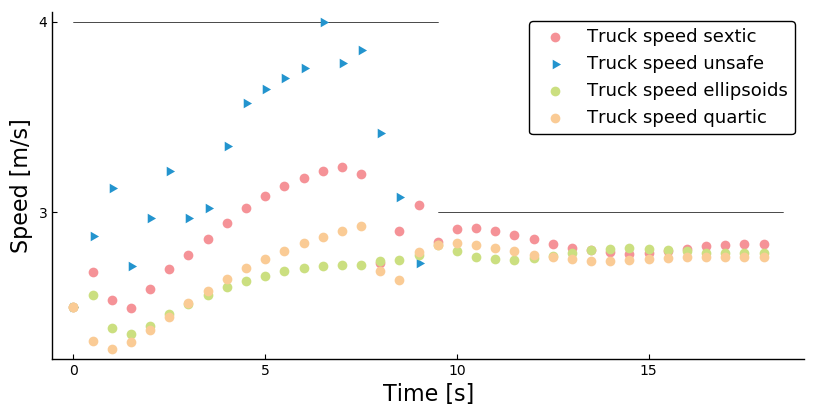

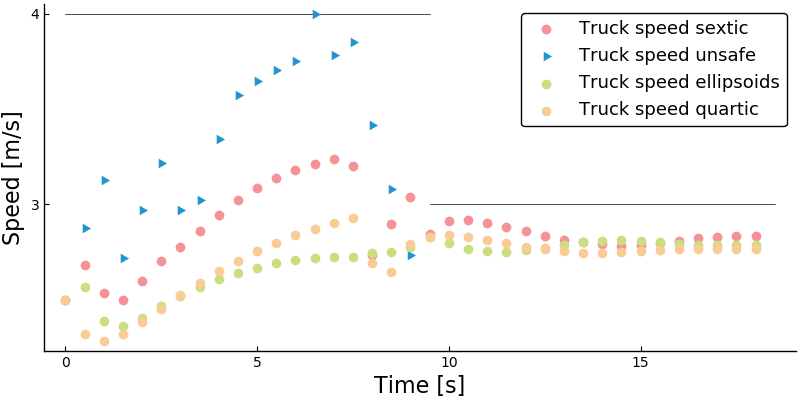

In [113]:
baseplot("Speed [m/s]", v_shift .+ [vmin, (vmin + v[1])/2, v[1], vmax])
limit_line(t[1], tswitch[1], v_shift + vmax)
limit_line(tswitch[1], t[end], v_shift + v[1])
mini = Inf
maxi = 35
for (s, (x, y)) in XY
    v1 = x[:, state_dim-2]
    v0 = x[:, state_dim-1]
    #:none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].
    issafe = s[1] != 'u'
    ms = 7 + (issafe ? 0 : 1)
    #Plots.scatter!(t[1:end-1], v1[1:end], label="Trailer speed $s", markersize=ms, markershape=issafe ? :diamond : :utriangle, markerstrokewidth=0)
    v0 = v0[1:end-1]
    Plots.scatter!(t[1:(length(v0))], v_shift .+ v0, color = colors[s], label="Truck speed $s",
                   markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    mini = min(mini, minimum(v1), minimum(v0))
    maxi = max(maxi, maximum(v1), maximum(v0))
end
#Plots.plot!(tswitch, [mini, maxi])
#Plots.plot!(tswitch, [mini, maxi], linewidth=2, label="")
if length(XY) == 1
    #_savefig("UnsafeSpeed")
else
    #@assert length(XY) == 3
    #_savefig("Speed")
end
_savefig("Speed")
Plots.plot!()

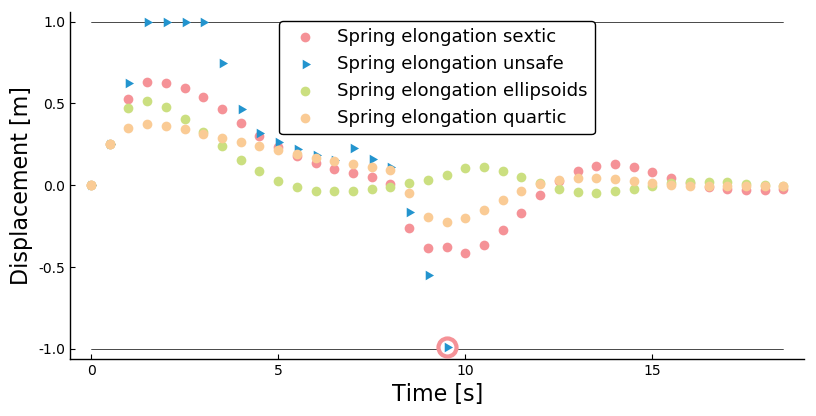

In [120]:
baseplot("Displacement [m]", [-D, -D/2, 0.0, D/2, D]) #, ylims=(-(D+0.05), D+0.55))
limit_line(t[1], t[end], -D)
limit_line(t[1], t[end], D)
for (s, (x, y)) in XY
    dist = x[:, 1]
    issafe = s[1] != 'u'
    ms = 7 + (issafe ? 0 : 1)
    if !issafe
        # Choose from :none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].

        Plots.scatter!([t[length(dist)]], [dist[end]], markersize=ms+5, markerstrokewidth=3,
            markershape=:circle, markercolor=:white, markerstrokecolor = red, label="")#, label="Constraint violation for $s")
    end
    Plots.scatter!(t[1:length(dist)], dist, label="Spring elongation $s", color = colors[s],
        markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
end
Plots.plot!()
#Plots.plot!(tswitch, [-.5, .5], label="")
_savefig("Elongation")

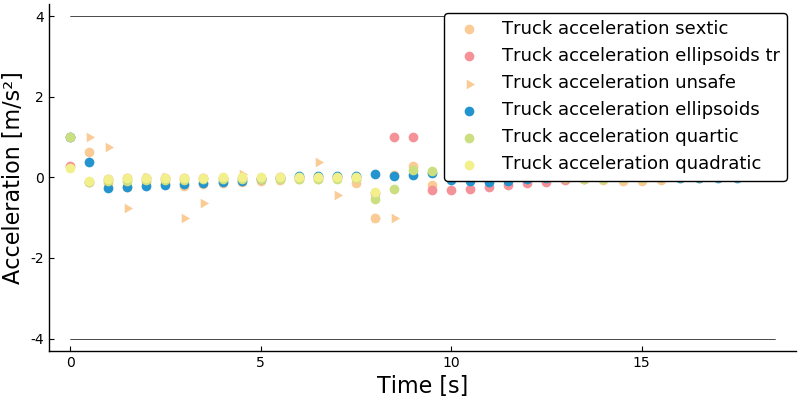

In [63]:
Plots.plot(legendfont=Plots.font(13), guidefont=Plots.font(16), tickfont=Plots.font(10), size=plotsize, grid=false, ylim=(-4.3, 4.3), xlabel="Time [s]", ylabel="Acceleration [m/s²]")
Plots.plot!([0, t[end]], [-4, -4], linewidth=0.5, color=:black, label="")
Plots.plot!([0, t[end]], [4, 4], linewidth=0.5, color=:black, label="")
for (s, (x, y)) in XY
    u = x[:, 4]
    issafe = s[1] != 'u'
    u = u[1:end-2]
    ms = 7 + (issafe ? 0 : 1)
    if !issafe
        # Choose from :none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].

        #Plots.scatter!([t[length(u)]], [u[end]], markersize=ms+5, markerstrokewidth=3, markershape=:circle, markercolor=:white, markerstrokecolor = red, label="Constraint violation for $s")
    end
    Plots.scatter!(t[1:length(u)], u, label="Truck acceleration $s", color = colors[s],
        markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    Plots.scatter!()
end
#Plots.plot!(tswitch, [-U, U], label="")
if length(XY) == 1
    #_savefig("UnsafeAcceleration")
else
    #@assert length(XY) == 3
    #_savefig("Acceleration")
end
Plots.plot!()

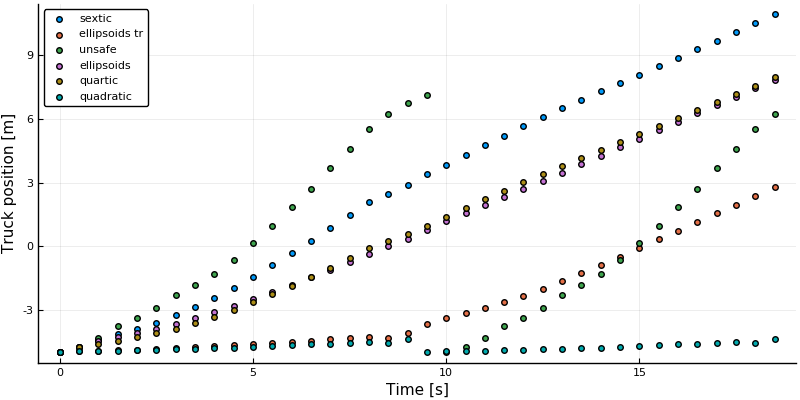

In [62]:
Plots.plot(size=(800, 400), xlabel="Time [s]", ylabel="Truck position [m]")
for (s, (x, y)) in XY
    Plots.plot!(t, y, label=s)
end
Plots.plot!()
#Plots.plot!(tswitch, collect(extrema(XY["unsafe optimal"][2])), label="")
#_savefig("Position")

# Sets

In [ ]:
sols = fullsolve(minsafe-1, M, h -> Ellipsoid(point=h), volume_heuristic=nth_root, oneshot=false, onlyone=false);

In [8]:
sols_4 = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=4, point=h));

In [10]:
sols_2 = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h));

In [19]:
U

4.0

length(sols) = 73
((SOS.SetProg).Sets).dimension(sols[1]) = 4
stateset(system(M, minsafe - 1), 1) = HalfSpace([-1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([1.0, 0.0, 0.0, 0.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, -1.0], 1.0) ∩ HalfSpace([0.0, 0.0, 0.0, 1.0], 1.0) ∩ HalfSpace([0.0, -1.0, 0.0, 0.0], -1.0) ∩ HalfSpace([0.0, 0.0, -1.0, 0.0], -1.0) ∩ HalfSpace([0.0, 1.0, 0.0, 0.0], 15.6) ∩ HalfSpace([0.0, 0.0, 1.0, 0.0], 15.6)


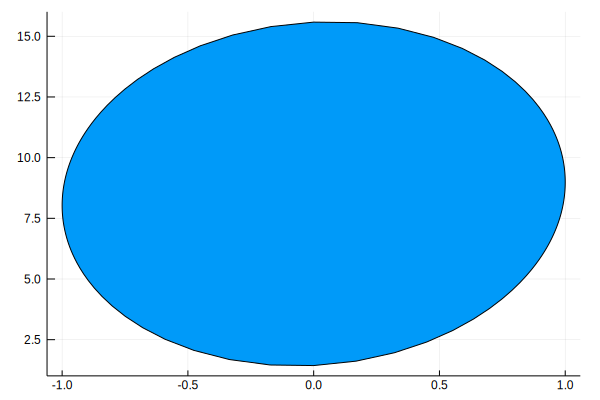

In [23]:
using Plots
@show length(sols)
@show SOS.SetProg.Sets.dimension(sols[1])
@show stateset(system(M, minsafe-1), 1)
plot(project(sols[1], [1, 2]), npoints=256)

length(sols_4) = 4


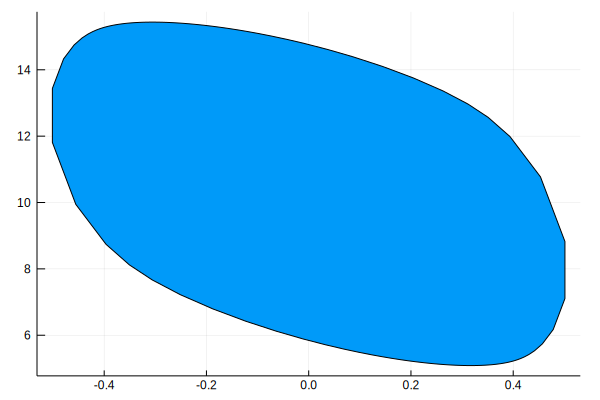

In [16]:
using Plots
@show length(sols_4)
plot(project(sols_4[1], [1, 3]), npoints=256)